In [1]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Train and Evaluate a single model

### Setup Parameters

In [2]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [3]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [4]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'


if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

### Instanciate Model

In [5]:
model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500

model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)


### Training

In [6]:
model.train(trainloader, validloader)

[00:00] Epoch 1/500 - Train Loss : 1.018522 / Val Loss : 1.008463
[00:40] Epoch 100/500 - Train Loss : 0.959409 / Val Loss : 1.022310
[01:21] Epoch 200/500 - Train Loss : 0.873286 / Val Loss : 1.037162
[02:00] Epoch 300/500 - Train Loss : 0.785908 / Val Loss : 1.166828
[02:37] Epoch 400/500 - Train Loss : 0.740558 / Val Loss : 1.239068
[03:18] Epoch 500/500 - Train Loss : 0.696807 / Val Loss : 1.348272
Train MAE : 0.6169 | Train MAPE  : 2.4179 | Train RSME : 0.6693 | Train Theil-U 0.5453
Valid MAE : 0.9045 | Valid MAPE  : 3.0945 | Valid RSME : 1.3483 | Valid Theil-U 0.7181


### Evaluation

In [7]:
if NNtype != "PSN":
    model.evaluate(testloader, mu=testmu, sigma=testsigma)
else:
    model.evaluate(testloader, min_=min_, max_=max_)

Normalized Test MAE : 0.006161 | Test MAPE  : 550.493826 | Test RMSE : 0.000064 | Test Theil-U 0.706910


In [9]:
model.evaluate_bis(testloader, mu=testmu, sigma=testsigma)

Normalized Test MAE : 0.006161 | Test MAPE  : 550.493826 | Test RMSE : 0.000064 | Test Theil-U 0.706910


### PREDICT

(array([  1.,   3.,   8.,  25.,  60., 128.,  64.,  18.,   8.,   6.]),
 array([-0.01639144, -0.01341877, -0.0104461 , -0.00747343, -0.00450076,
        -0.00152809,  0.00144458,  0.00441725,  0.00738992,  0.01036259,
         0.01333526]),
 <a list of 10 Patch objects>)

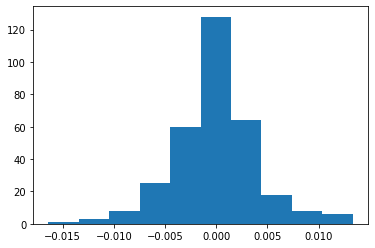

In [10]:
if NNtype != "PSN":
    predictions = model.predict(testloader, mu=testmu, sigma=testsigma)
else:
    predictions = model.predict(testloader, min_=min_, max_=max_)
plt.hist(np.array(predictions))

Text(0.5, 1.0, 'UnNormalized')

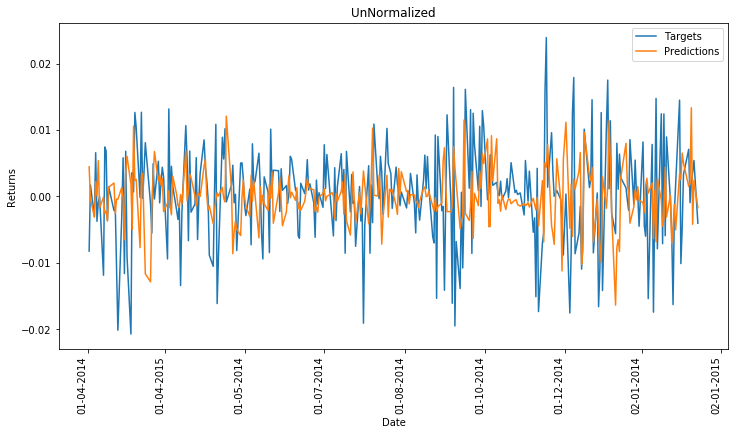

In [11]:
if NNtype == "PSN":
    targets = testdf["Target"]*(max_ - min_) + min_
else :
    targets = testdf["Target"].tolist()

dataDf = pd.DataFrame({'Predictions':predictions, 'Targets':targets})
dataDf.index = testdf.index
dataDf

fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title("UnNormalized")

## Train and Evaluate All Models

In [15]:
ETF = 'SPY'
NNtype = 'RNN'

print("="*10 + ETF + " - " + NNtype + "="*10)
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
elif ETF == "QQQ":
    inputs_lag = cfg.QQQfeatures[NNtype]

traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

model.train(trainloader, validloader)

==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.037194 / Val Loss : 0.993890
[00:59] Epoch 100/500 - Train Loss : 0.740638 / Val Loss : 1.125260
[01:58] Epoch 200/500 - Train Loss : 0.696965 / Val Loss : 1.236564
[03:01] Epoch 300/500 - Train Loss : 0.686903 / Val Loss : 1.247640
[03:59] Epoch 400/500 - Train Loss : 0.680224 / Val Loss : 1.251864
[04:55] Epoch 500/500 - Train Loss : 0.676785 / Val Loss : 1.255328
Train MAE : 0.6228 | Train MAPE  : 3.1657 | Train RSME : 0.6562 | Train Theil-U 0.5111
Valid MAE : 0.8528 | Valid MAPE  : 1.8600 | Valid RSME : 1.2553 | Valid Theil-U 0.6926


Normalized Test MAE : 0.006249 | Test MAPE  : 2.440355 | Test RMSE : 0.000068 | Test Theil-U 0.705020
Test MAE : 0.006247 | Test MAPE  : 2.281802 | Test RMSE : 0.000068 | Test Theil-U 0.700986


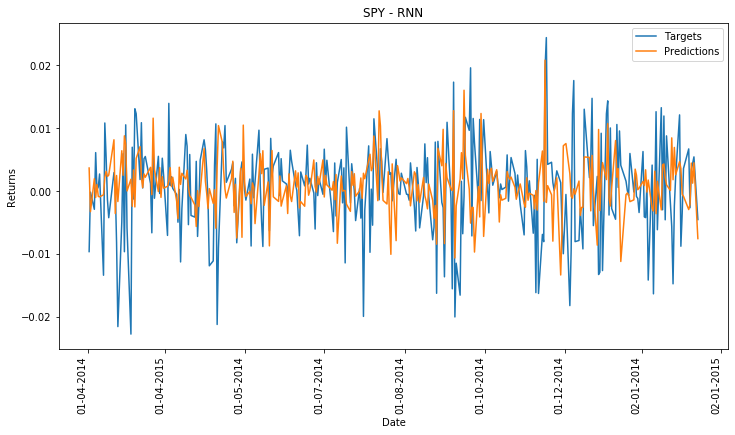

In [21]:
if NNtype == "PSN":
    model.evaluate(testloader, min_=min_, max_=max_)
    preds = model.predict(testloader, min_=min_, max_=max_)
    labels = testdf["Target"]*(max_ - min_) + min_
else :
    model.evaluate(testloader, sigma=testsigma, mu=testmu)
    preds = model.predict(testloader, sigma=testsigma, mu=testmu)
    labels = np.array(testdf["Target"].tolist())

testRMSE = mean_squared_error(labels, preds)
testMAE = mean_absolute_error(labels, preds)
testMAPE = mean_absolute_percentage_error(labels, preds)
testTheilU = theilU(labels, preds)

print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

## plot Target and Predictions UnNormalized ##
dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
dataDf.index = testdf.index
dataDf

fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title(ETF + " - " + NNtype)
plt.show()

## Train all Models and create Table4

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.007169 / Val Loss : 0.988075
[00:41] Epoch 100/500 - Train Loss : 0.920525 / Val Loss : 1.002674
[01:21] Epoch 200/500 - Train Loss : 0.850672 / Val Loss : 1.061435
[02:03] Epoch 300/500 - Train Loss : 0.811242 / Val Loss : 1.125901
[02:40] Epoch 400/500 - Train Loss : 0.787137 / Val Loss : 1.150376
[03:16] Epoch 500/500 - Train Loss : 0.781190 / Val Loss : 1.182369
Train MAE : 0.6376 | Train MAPE  : 2.8048 | Train RSME : 0.7963 | Train Theil-U 0.5840
Valid MAE : 0.8373 | Valid MAPE  : 1.6769 | Valid RSME : 1.1824 | Valid Theil-U 0.7260
Normalized Test MAE : 0.005930 | Test MAPE  : 2.697492 | Test RMSE : 0.000064 | Test Theil-U 0.725102
Test MAE : 0.005920 | Test M

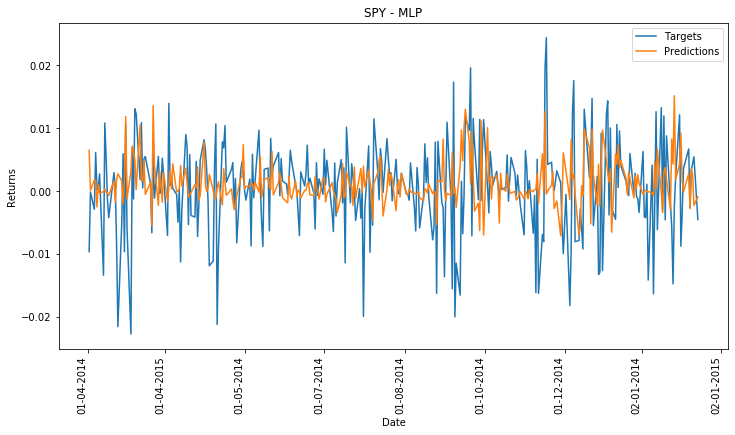




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.055761 / Val Loss : 0.968742
[00:52] Epoch 100/500 - Train Loss : 0.773027 / Val Loss : 1.168926
[01:44] Epoch 200/500 - Train Loss : 0.751028 / Val Loss : 1.197709
[02:36] Epoch 300/500 - Train Loss : 0.745963 / Val Loss : 1.204724
[03:27] Epoch 400/500 - Train Loss : 0.743600 / Val Loss : 1.207024
[04:19] Epoch 500/500 - Train Loss : 0.742127 / Val Loss : 1.208200
Train MAE : 0.6489 | Train MAPE  : 2.6546 | Train RSME : 0.7133 | Train Theil-U 0.5478
Valid MAE : 0.8587 | Valid MAPE  : 2.2796 | Valid RSME : 1.2082 | Valid Theil-U 0.6885
Normalized Test MAE : 0.006691 | Test MAPE  : 3.876991 | Test RMSE : 0.000074 | Test Theil-U 0.728154
Test MAE : 0.006683 | Test MAPE  : 3.072235 | Test RMSE : 0.000073 | Test Theil-U 0.7

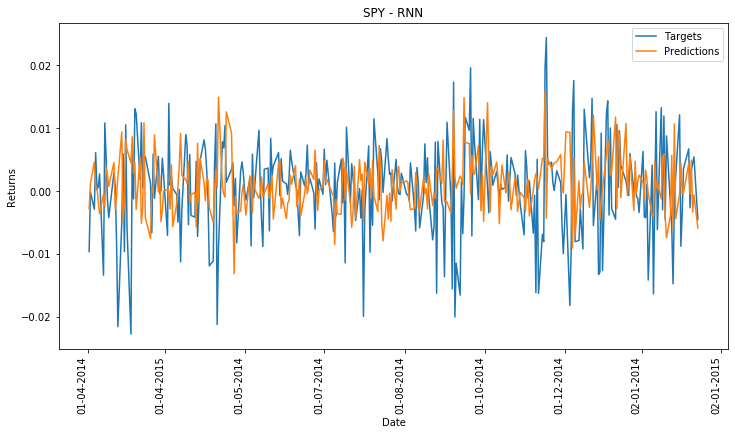




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.020829 / Val Loss : 0.015236
[00:35] Epoch 100/200 - Train Loss : 0.012377 / Val Loss : 0.007507
[01:14] Epoch 200/200 - Train Loss : 0.012600 / Val Loss : 0.007482
Train MAE : 0.0913 | Train MAPE  : 0.1617 | Train RSME : 0.0144 | Train Theil-U 0.1017
Valid MAE : 0.0737 | Valid MAPE  : 0.1194 | Valid RSME : 0.0075 | Valid Theil-U 0.0744
Normalized Test MAE : 0.008359 | Test MAPE  : 5.145128 | Test RMSE : 0.000096 | Test Theil-U 0.710515
Test MAE : 0.008359 | Test MAPE  : 5.145146 | Test RMSE : 0.000096 | Test Theil-U 0.710515


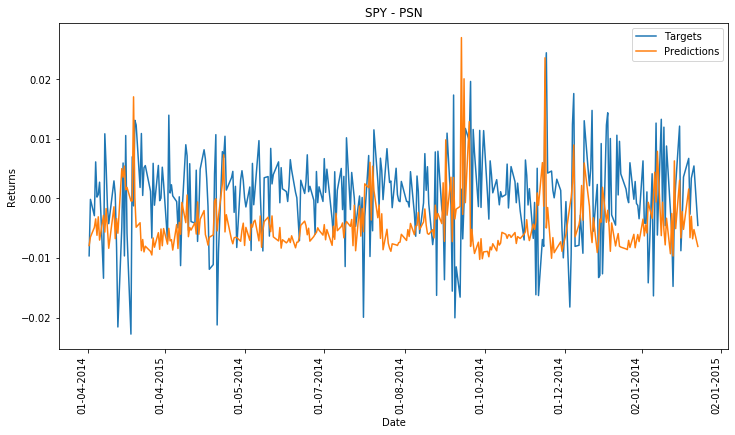




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.036422 / Val Loss : 1.012601
[00:40] Epoch 100/500 - Train Loss : 0.957069 / Val Loss : 1.032937
[01:18] Epoch 200/500 - Train Loss : 0.853657 / Val Loss : 1.054334
[01:57] Epoch 300/500 - Train Loss : 0.717291 / Val Loss : 1.188496
[02:34] Epoch 400/500 - Train Loss : 0.682037 / Val Loss : 1.312288
[03:10] Epoch 500/500 - Train Loss : 0.671258 / Val Loss : 1.358199
Train MAE : 0.6194 | Train MAPE  : 2.5838 | Train RSME : 0.6457 | Train Theil-U 0.5154
Valid MAE : 0.8982 | Valid MAPE  : 2.4401 | Valid RSME : 1.3582 | Valid Theil-U 0.7089
Normalized Test MAE : 0.006104 | Test MAPE  : 257.377113 | Test RMSE : 0.000067 | Test Theil-U 0.689898
Test MAE : 0.006101 | T

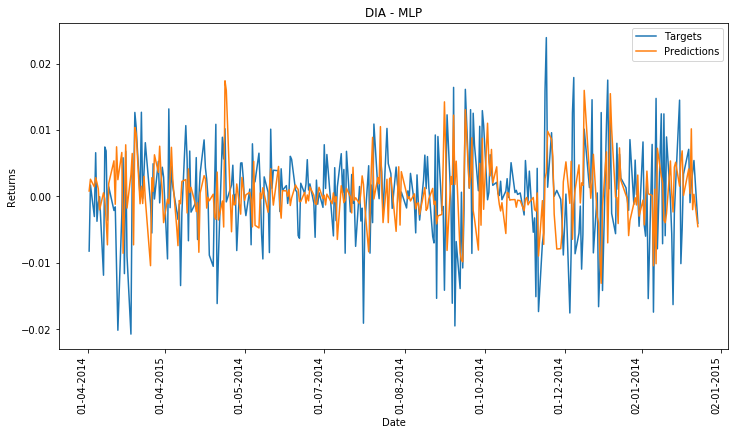




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.041196 / Val Loss : 0.999674
[00:51] Epoch 100/500 - Train Loss : 0.752144 / Val Loss : 1.308481
[01:42] Epoch 200/500 - Train Loss : 0.726713 / Val Loss : 1.360557
[02:34] Epoch 300/500 - Train Loss : 0.716124 / Val Loss : 1.392192
[03:26] Epoch 400/500 - Train Loss : 0.709873 / Val Loss : 1.412357
[04:18] Epoch 500/500 - Train Loss : 0.705845 / Val Loss : 1.425011
Train MAE : 0.6086 | Train MAPE  : 3.2056 | Train RSME : 0.6664 | Train Theil-U 0.5184
Valid MAE : 0.9191 | Valid MAPE  : 2.4748 | Valid RSME : 1.4250 | Valid Theil-U 0.7206
Normalized Test MAE : 0.006432 | Test MAPE  : 375.157197 | Test RMSE : 0.000071 | Test Theil-U 0.725779
Test MAE : 0.006445 | Test MAPE  : 2.548042 | Test RMSE : 0.000071 | Test Theil-U 0

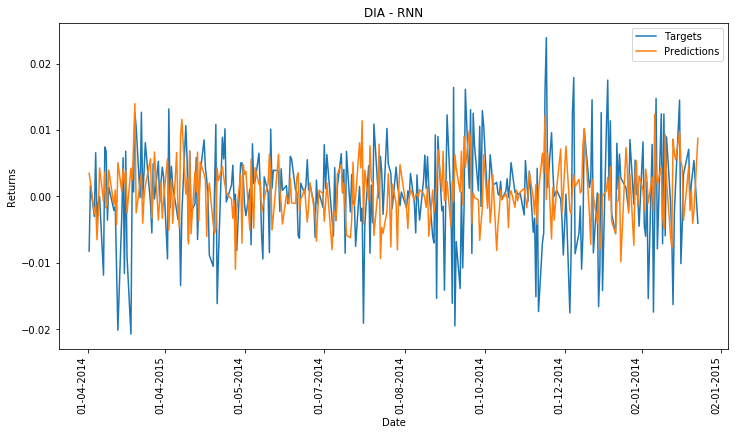




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.020694 / Val Loss : 0.013876
[00:35] Epoch 100/200 - Train Loss : 0.013813 / Val Loss : 0.007034
[01:10] Epoch 200/200 - Train Loss : 0.013812 / Val Loss : 0.007215
Train MAE : 0.0864 | Train MAPE  : 0.1661 | Train RSME : 0.0137 | Train Theil-U 0.1005
Valid MAE : 0.0700 | Valid MAPE  : 0.1166 | Valid RSME : 0.0072 | Valid Theil-U 0.0734
Normalized Test MAE : 0.006785 | Test MAPE  : 17151.895588 | Test RMSE : 0.000069 | Test Theil-U 0.725347
Test MAE : 0.006785 | Test MAPE  : 3325712815987.890137 | Test RMSE : 0.000069 | Test Theil-U 0.725347


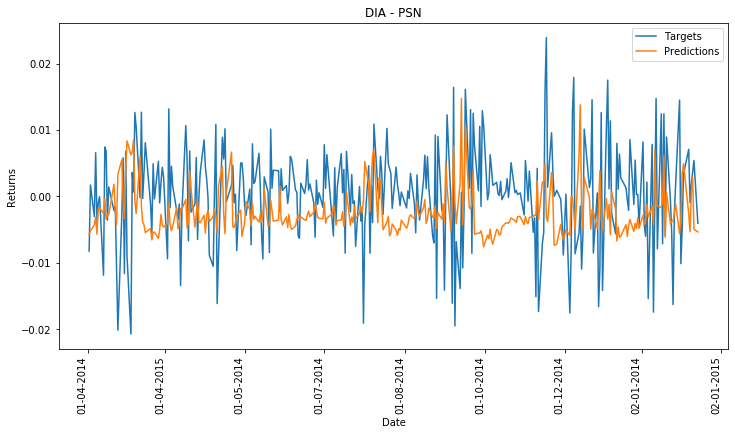




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.017632 / Val Loss : 0.989863
[00:36] Epoch 100/500 - Train Loss : 0.954793 / Val Loss : 0.985499
[01:12] Epoch 200/500 - Train Loss : 0.853327 / Val Loss : 1.052507
[01:48] Epoch 300/500 - Train Loss : 0.788309 / Val Loss : 1.166147
[02:24] Epoch 400/500 - Train Loss : 0.732340 / Val Loss : 1.274267
[03:01] Epoch 500/500 - Train Loss : 0.703273 / Val Loss : 1.297049
Train MAE : 0.6308 | Train MAPE  : 2.3571 | Train RSME : 0.6729 | Train Theil-U 0.5276
Valid MAE : 0.8672 | Valid MAPE  : 3.4615 | Valid RSME : 1.2970 | Valid Theil-U 0.7291
Normalized Test MAE : 0.007618 | Test MAPE  : 4.876283 | Test RMSE : 0.000101 | Test Theil-U 0.710832
Test MAE : 0.007633 | Tes

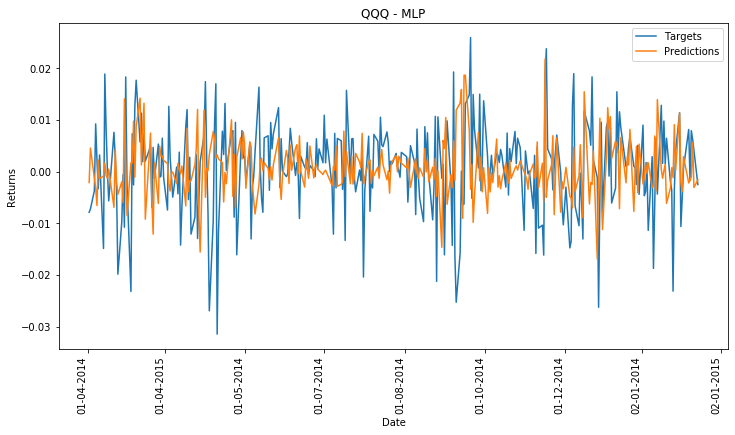




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.068080 / Val Loss : 0.999859
[00:51] Epoch 100/500 - Train Loss : 0.754201 / Val Loss : 1.212518
[01:43] Epoch 200/500 - Train Loss : 0.619848 / Val Loss : 1.443288
[02:37] Epoch 300/500 - Train Loss : 0.599650 / Val Loss : 1.454391
[03:32] Epoch 400/500 - Train Loss : 0.585282 / Val Loss : 1.451651
[04:24] Epoch 500/500 - Train Loss : 0.577003 / Val Loss : 1.446471
Train MAE : 0.5838 | Train MAPE  : 2.6429 | Train RSME : 0.5462 | Train Theil-U 0.4443
Valid MAE : 0.9486 | Valid MAPE  : 3.6085 | Valid RSME : 1.4465 | Valid Theil-U 0.7179
Normalized Test MAE : 0.008294 | Test MAPE  : 9.200389 | Test RMSE : 0.000116 | Test Theil-U 0.726079
Test MAE : 0.008308 | Test MAPE  : 2.710658 | Test RMSE : 0.000116 | Test Theil-U 0

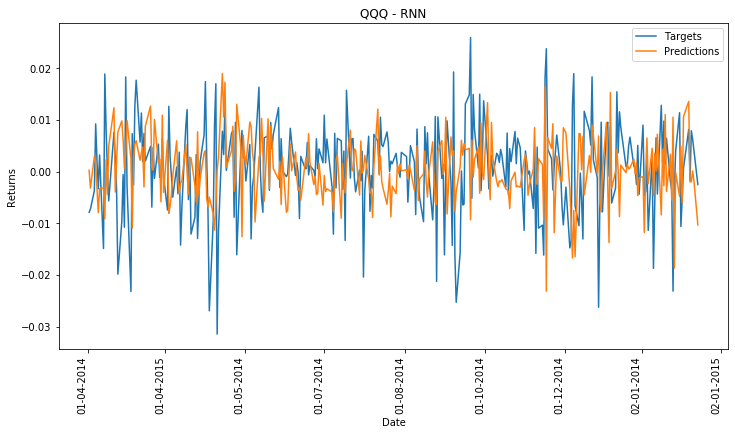




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018486 / Val Loss : 0.011343
[00:36] Epoch 100/200 - Train Loss : 0.014429 / Val Loss : 0.005915
[01:10] Epoch 200/200 - Train Loss : 0.014140 / Val Loss : 0.006071
Train MAE : 0.0890 | Train MAPE  : 0.1706 | Train RSME : 0.0138 | Train Theil-U 0.1028
Valid MAE : 0.0619 | Valid MAPE  : 0.1075 | Valid RSME : 0.0061 | Valid Theil-U 0.0688
Normalized Test MAE : 0.007413 | Test MAPE  : 3983.362621 | Test RMSE : 0.000085 | Test Theil-U 0.766191
Test MAE : 0.007413 | Test MAPE  : 1788648331337.327881 | Test RMSE : 0.000085 | Test Theil-U 0.766191


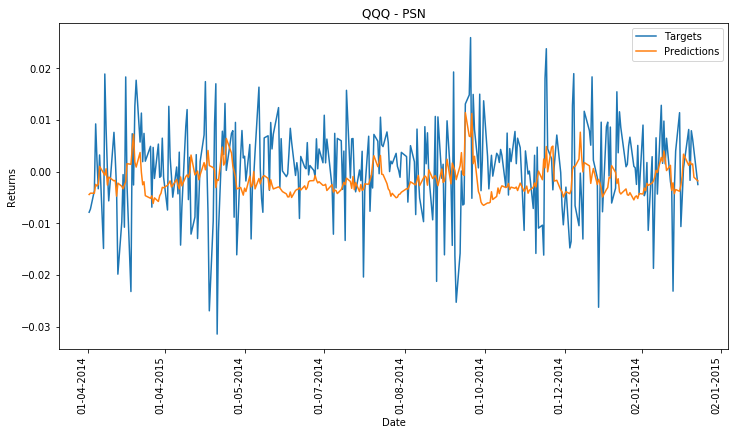

In [2]:
Table4 = pd.DataFrame()

models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        if NNtype != "PSN":
            trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
            validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
            testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

        else:
            max_ = traindf.Return.max()
            min_ = traindf.Return.min()
            traindf = (traindf - min_) / (max_ - min_)
            validdf = (validdf - min_) / (max_ - min_)
            testdf = (testdf - min_) / (max_ - min_)

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)
            
            
        model = NN.Model(NNtype)
        epochs = 200 if NNtype == "PSN" else 500
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    epochs,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        
        if NNtype == "PSN":
            model.evaluate(testloader, min_=min_, max_=max_)
            preds = model.predict(testloader, min_=min_, max_=max_)
            labels = testdf["Target"]*(max_ - min_) + min_
        else :
            model.evaluate(testloader, sigma=testsigma, mu=testmu)
            preds = model.predict(testloader, sigma=testsigma, mu=testmu)
            labels = np.array(testdf["Target"].tolist())
        
        testRMSE = mean_squared_error(labels, preds)
        testMAE = mean_absolute_error(labels, preds)
        testMAPE = mean_absolute_percentage_error(labels, preds)
        testTheilU = theilU(labels, preds)

        print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))
        
        ## plot Target and Predictions UnNormalized ##
        dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
        dataDf.index = testdf.index
        dataDf

        fig, ax = plt.subplots(figsize = (12,6))
        fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
        sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

        x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
        ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
        ax.set_ylabel('Returns')
        ax.set_title(ETF + " - " + NNtype)
        plt.show()
        
        models[ETF][NNtype] = model
        
        Table[NNtype] = [testMAE, testMAPE, testRMSE, testTheilU]
        Table["ETF"] = ETF 
        print("\n"*2)
     
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
# Table4.to_csv("table/Table4norm.csv", index=True) 

### Save Models

In [3]:
Table4.to_csv("table/Table4normChay.csv", index=True)
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models_norm", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models_norm", ETF, NNtype, "ckpt.pth"))

### Load Ckpt

In [71]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.005390 | Test MAPE  : 3.646229 | Test RSME : 0.000052 | Test Theil-U 0.926919


# To work

# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [12]:
Table4

NameError: name 'Table4' is not defined